VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training Deep Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from libs.dkf_lib import seed_everything, DeepKalmanFilter
from libs.dkf_lib import loss_function, train
from libs.dkf_lib import BetaLinearScheduler, BetaThresholdScheduler
from libs.dkf_lib import plot_losses, sample_predictions

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3090
Total GPU Memory: 23.7 GB


# Modèle

### Structure SSM (Single State Model pour variables latentes + VAE pour observations):

- $z_t$ variables latentes forment une chaîne de Markov, transition $p(z_t \vert z_{t-1})$
- $x_t$ observations, modèle $p_{\theta_x}(x_t \vert z_t)$
- NB : pas de commande/input $u_t$ ici

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/Model_DKF.png" width="500"/>
</div>

### Deep Kalman Filter :

\begin{align}
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
d_z(z_{t-1}) &= [ \mu_{\theta_z}(z_{t-1}), \sigma_{\theta_z}(z_{t-1}) ] \\
p_{\theta_x}(x_t \vert z_{t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_{t}), \text{diag}(\sigma_{\theta_x}^{2}(z_{t}))) \\
d_x(z_{t}) &= [ \mu_{\theta_x}(z_{t}), \sigma_{\theta_x}(z_{t}) ] \\
\end{align}

où $d_x, d_z$ sont des réseaux.

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
&= \prod_{t=1}^T p_{\theta} (z_t \vert z_{t-1}, x_{t:T} )
\end{align}

où la première écriture est l'application de la chain rule, et la deuxième est un résultat de D-séparation (latentes à dépendance Markovienne).

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{t-1}, x_{t:T})
\end{align}

On voit que l'inférence prend en compte les observations futures $x_{t:T}$ (comme le Kalman smoother par exemple)

# Implémentation de l'inférence

- **backward RNN** (dans les faits, un LSTM) pour encoder les $x_{t:T}$ par les hidden states $h_t$ : 

\begin{align}
h_t = \text{LSTM}(h_{t+1}, x_t)
\end{align}

- **combiner** (réseau MLP) pour aggréger $h_t$ et $z_{t-1}

\begin{align}
g_t = \text{Combiner}(h_t, z_{t-1})
\end{align}

- **Encoder** (réseau MLP) pour inférer les paramètres du posterior:

\begin{align}
e_z(g_t) &= [ \mu_\phi(g_t), \sigma_\phi(g_t)] \\
q_\phi(z_t \vert g_t) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t)))
\end{align}

NB : il existe d'autres formulations du posterior approximé $q_\phi$, qui peuvent faire intervenir un forward LSTM.

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation générique se simplifie dans le cas du DKF en :

\begin{align}
\mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T \mathbb{E}_{q_\phi(z_t \vert x_{1:T})} \log(p_{\theta_x}(x_t \vert z_t)) -
\sum_{t=1}^T \mathbb{E}_{q_\phi(z_{t-1} \vert x_{1:T})} \text{D}_{\text{KL}} \left[ q_\phi(z_t \vert z_{t-1}, x_{t:T}) \vert\vert 
p_{\theta_z}(z_t \vert z_{t-1}) \right]
\end{align}

Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align}

# Parameters

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 2 # Dimension of the latent space
H_DIM = 16 # Dimension of the hidden state of the LSTM network(s)
G_DIM = 2 # Dimension of the output of the combiner
INTERMEDIATE_LAYER_DIM = 16 # Dimension of the intermediate layers of the MLPs

# Toy Case : Data Generation for Time Series Forecasting

In [6]:
n_steps = 500
n_ahead = 10
n_series = 100

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [7]:
s = generate_time_series(n_series, n_steps+n_ahead)

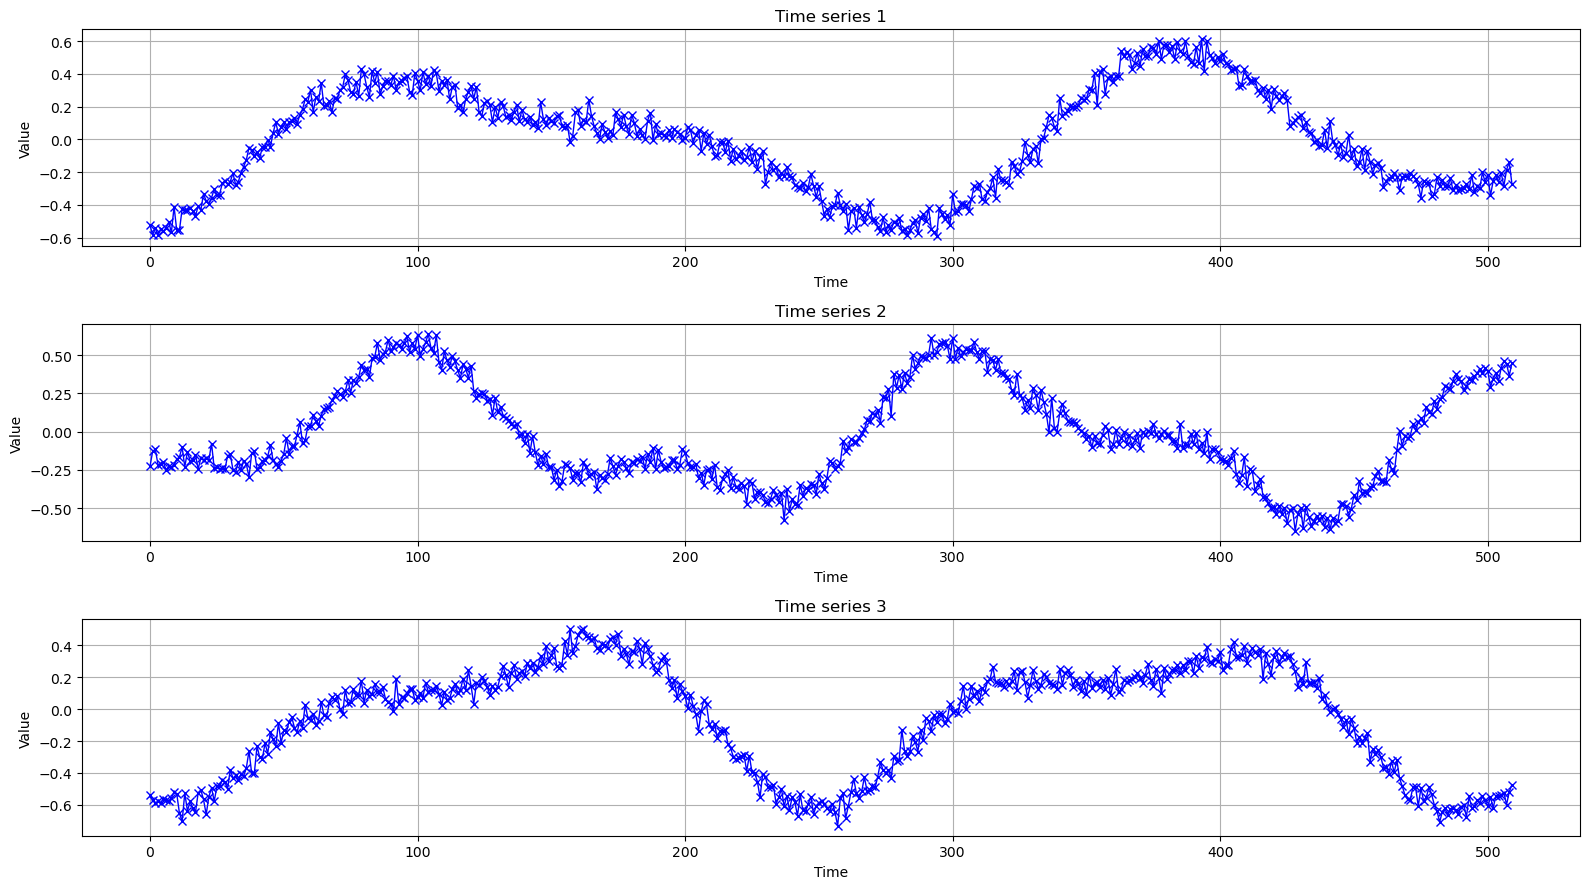

In [8]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [9]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 500)
y_train shape: (80, 10)
X_valid shape: (20, 500)
y_valid shape: (20, 10)


In [10]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16   # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Baseline : RNN

In [11]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=n_ahead, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [12]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=n_ahead,
    hidden_dim=128,
    num_layers=4,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
# Test dimensions

x = torch.randn(BATCH_SIZE, 50, 1).to(device)
y = rnn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {y.shape}")

input shape: torch.Size([16, 50, 1])
output shape: torch.Size([16, 10, 1])


In [14]:
criterion = nn.MSELoss()

In [15]:
lr = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
num_epochs = 200

In [16]:
train_losses = []
valid_losses = []

print(f"Start training RNN model for {num_epochs} epochs")

for i in range(num_epochs):
    # loop on training data
    rnn.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, n_ahead, 1)
        # print(f"target has shape {target.shape}")
        output = rnn(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader) 
    train_losses.append(epoch_loss)
    
    # test step
    rnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, n_ahead, 1)
            output = rnn(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(test_loader)
    valid_losses.append(epoch_loss)
    
    # report out
    if (i+1) % 10 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

Start training RNN model for 200 epochs
epoch   10/200, training loss = 4.0111e-02, validation loss = 2.5626e-02
epoch   20/200, training loss = 2.0320e-02, validation loss = 1.6025e-02
epoch   30/200, training loss = 1.1908e-02, validation loss = 1.5436e-02
epoch   40/200, training loss = 9.8373e-03, validation loss = 1.3387e-02
epoch   50/200, training loss = 8.7113e-03, validation loss = 1.2162e-02
epoch   60/200, training loss = 1.1862e-02, validation loss = 1.4911e-02
epoch   70/200, training loss = 1.2207e-02, validation loss = 1.5460e-02
epoch   80/200, training loss = 5.7652e-03, validation loss = 8.8547e-03
epoch   90/200, training loss = 7.9727e-03, validation loss = 8.6108e-03
epoch  100/200, training loss = 5.7552e-03, validation loss = 7.6185e-03
epoch  110/200, training loss = 7.6727e-03, validation loss = 8.8350e-03
epoch  120/200, training loss = 5.7348e-03, validation loss = 6.9207e-03
epoch  130/200, training loss = 5.7914e-03, validation loss = 9.0469e-03
epoch  140/

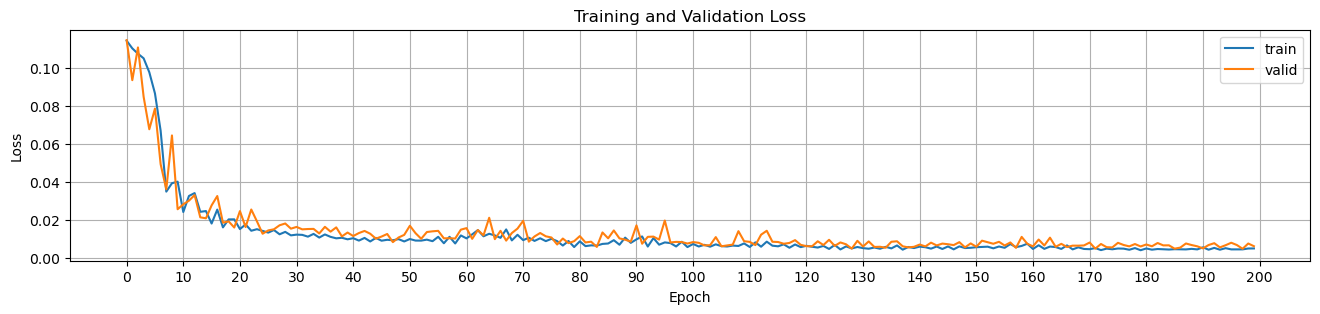

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, num_epochs+1, 10))
ax.set_xticklabels(np.arange(0, num_epochs+1, 10))
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.grid()
plt.show()

In [18]:
y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device).unsqueeze(-1)

# print(f"y_target shape: {y_target.shape}")
# print(f"y_pred shape: {y_pred.shape}")

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

# print(f"\n{np.mean(np.sqrt((y_target - y_pred) ** 2)):.4f} RMSE")

Loss finale = 6.2795e-03


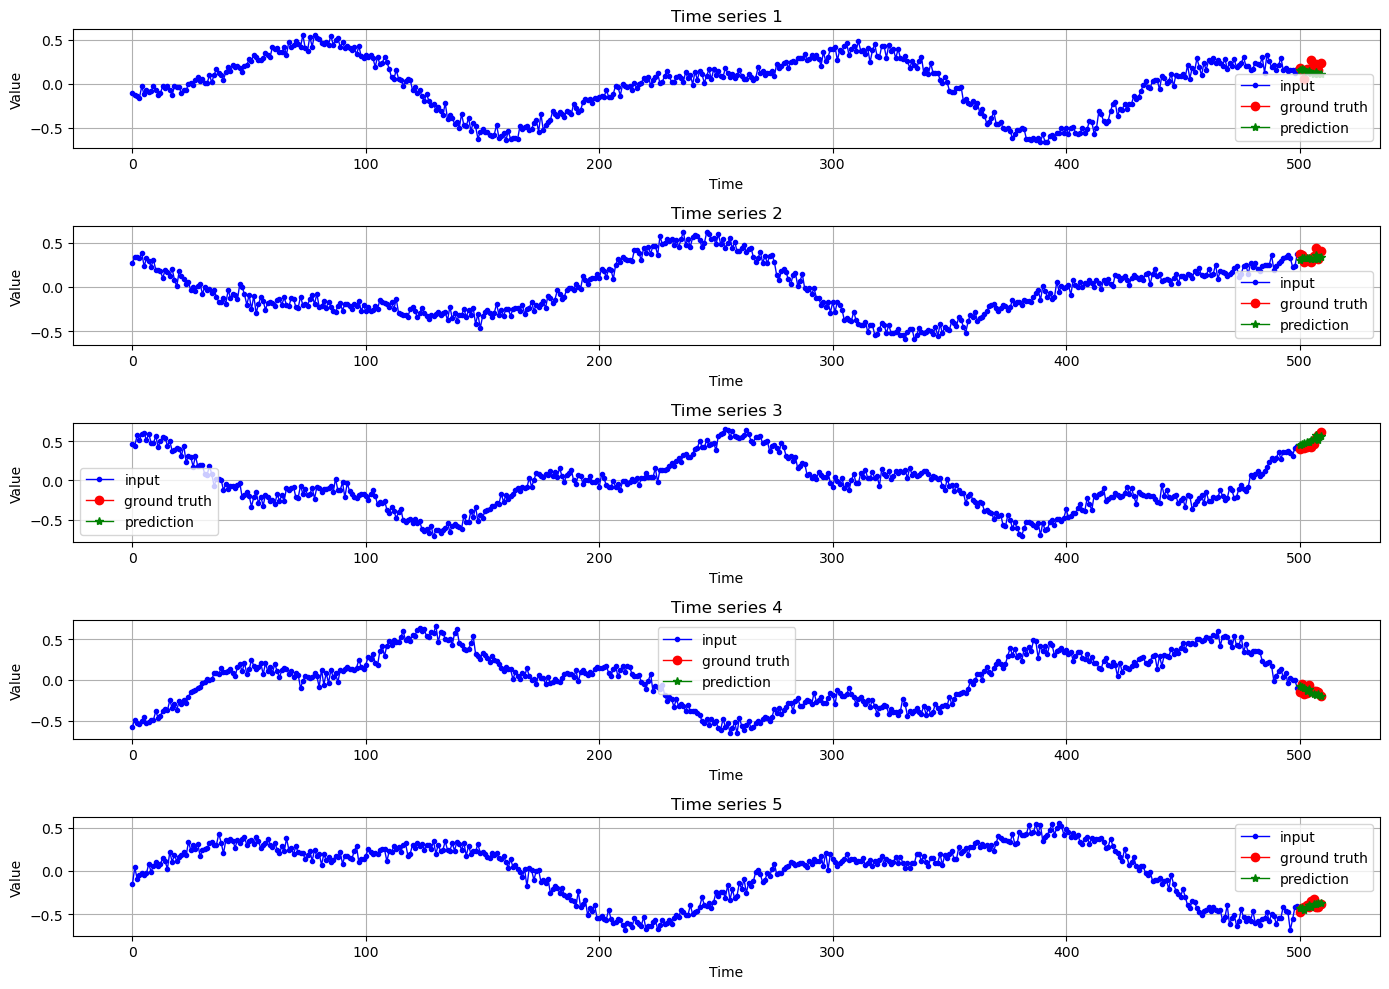

In [19]:
N = 5
fig, ax  = plt.subplots(N, 1, figsize=(14, 2 * N))
x_shift = X_valid.shape[-1]

for i in range(N):
    input = torch.tensor(X_valid[i], device=device).unsqueeze(0).unsqueeze(-1)
    # input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_valid[i], device=device).view(-1, n_ahead, 1)
    # target = target.permute(1, 0, 2)  # permute to (seq_len, batch_size, output_dim)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    
    ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker=".", linewidth=1, label="input")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
    ax[i].set_title(f"Time series {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Value")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Training DKF - XP 1

https://www.youtube.com/watch?v=rz76gYgxySo&list=WL&index=1&t=1618s&ab_channel=SimonLeglaive

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/DKF_Training.png" width="1000"/>
</div>

In [20]:
xdim = 1
latent_dim = 2
h_dim = 16
combiner_dim = 2
num_layers_rnn = 4

In [21]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = num_layers_rnn,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=2, hidden_dim=16, combiner_dim=2, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 16, num_layers=4)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)
DecoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_

In [22]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-3)
loss_fn = loss_function

K = 5

In [23]:
num_epochs = 300
n_displays = 60
display_frequency = int(num_epochs / n_displays)

In [24]:
# beta = 1e-3

# beta_scheduler = BetaLinearScheduler(
#     beta_start=1e-3,
#     beta_end=1.0,
#     epoch_start=150,
#     epoch_end=200,
#     num_epochs=None
# )

beta_scheduler = BetaThresholdScheduler(
    rec_loss_threshold=0.0,
    beta_start=1e-3,
    beta_end=1.0,
    num_epochs=100
)

print(beta_scheduler)

BetaThresholdScheduler(beta_start=1.000e-03, beta_end=1.000e+00, num_epochs=100, seuil rec_loss=0.000e+00)


In [25]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas = train(
    dkf, 
    optimizer, 
    loss_fn, 
    num_epochs=num_epochs, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    batch_size=BATCH_SIZE, 
    device=device, 
    beta=None, 
    beta_scheduler=beta_scheduler, 
    display_frequency=display_frequency, 
    K=K
)

Starting training...
GPU Name: NVIDIA GeForce RTX 3090
Total GPU Memory: 23.7 GB
Number of epochs: 300
Learning rate: 1.000e-03
Batch size: 16
Beta scheduler: BetaThresholdScheduler(beta_start=1.000e-03, beta_end=1.000e+00, num_epochs=100, seuil rec_loss=0.000e+00)
K = 5
Training set size: 80
Validation set size: 20
Device: cuda


Epoch     5/300 with beta = 1.00e-03 - TRAINING : Rec Loss: 3.9041e-01, KL Loss: 4.0686e-02, Total Loss: 9.8798e-01 - TEST : Rec Loss: 9.6777e-01, KL Loss: 1.0677e-01, Total Loss: 9.6686e-01
Epoch    10/300 with beta = 1.00e-03 - TRAINING : Rec Loss: 3.1950e-01, KL Loss: 8.1980e-02, Total Loss: 8.1439e-01 - TEST : Rec Loss: 7.9235e-01, KL Loss: 2.1027e-01, Total Loss: 7.9293e-01
Epoch    15/300 with beta = 1.00e-03 - TRAINING : Rec Loss: 2.2633e-01, KL Loss: 1.9501e-01, Total Loss: 5.8607e-01 - TEST : Rec Loss: 5.4869e-01, KL Loss: 4.9959e-01, Total Loss: 5.5355e-01
Epoch    20/300 with beta = 1.00e-03 - TRAINING : Rec Loss: 1.4001e-01, KL Loss: 3.4337e-01, T

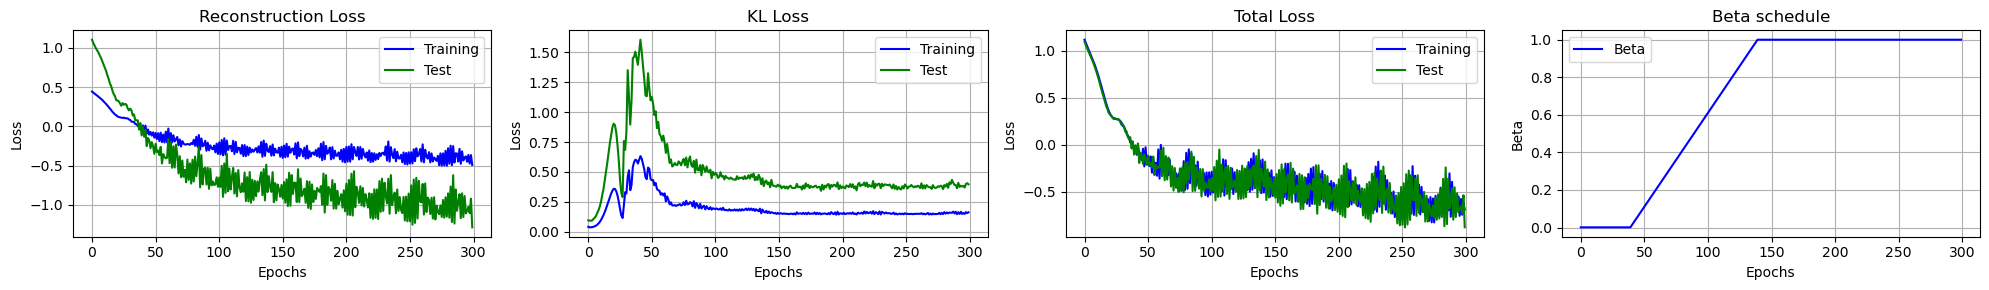

In [26]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas)

# Predictions / Générations

In [27]:
n_ahead = 100

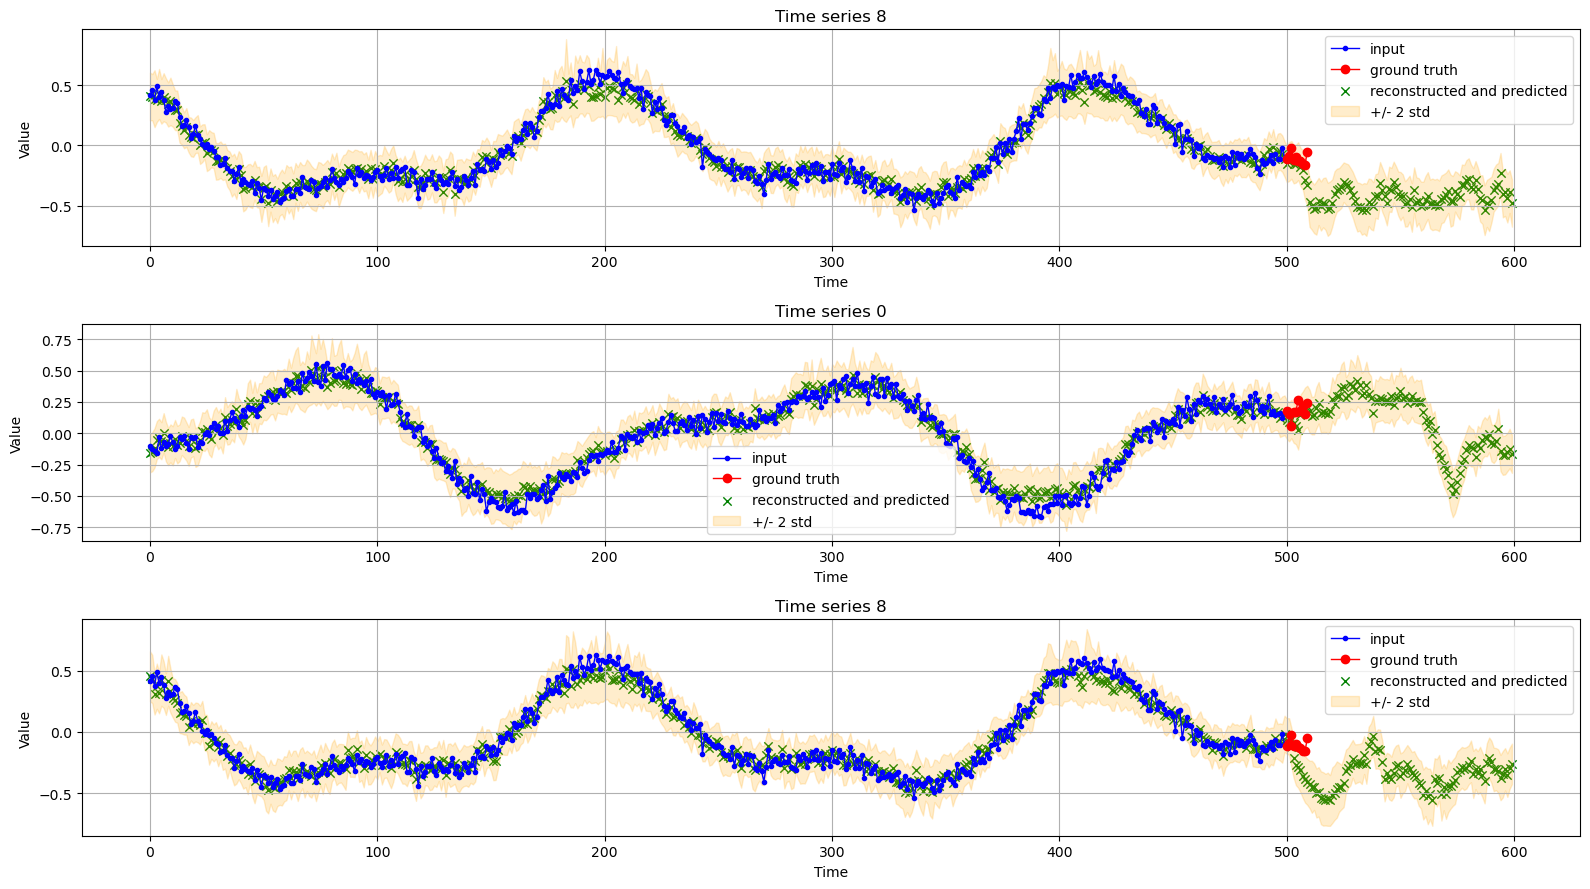

In [28]:
sample_predictions(N_SAMPLES=3, model=dkf, X_valid=X_valid, y_valid=y_valid, n_steps=n_steps, n_ahead=n_ahead, device=device)

# Commentaires à ce stade :

~~C1 - REVOIR LE TRAINING ! cf https://dynamicalvae.github.io/tuto_icassp2021/DVAE_tutorial.html (slide training DKF)~~

~~Q1 - L'ELBO contient une expectation de KLs entre les vraies posterieures et les approximées. Une méthode est mentionnée p64 du papier de l'INRIA.~~


~~Mon codage de la loss est-il correct ?~~

~~Q2 - A priori plus de problème de stabilité ? Mais on constate un changement de régime pendant le training. Est-ce que cela correspond à un maximum d'expressivité du modèle ? Ou autre chose (ie $\sigma_{\theta_x} \longrightarrow 0$?)~~

Q3 - Je calcule la prédiction en utilisant la moyenne de $p_{\theta_z}$ plutôt que celle de $q_\phi$ ... Mais ça se discute ?

~~Q4 - Comment arbitrer entre la KL et la reconstruction ? Piste 1 : faire un scheduler sur $\beta$ ? (cf papiers plus bas)~~

Q5 - Choix des différents paramètres ? Grid-search ? Early stopping + train till end of patience ? Autre ?

Q6 - Influence de K ? (nombre de samples pour calculer les expectations dans la loss)

~~Q7 - Architecture des réseaux : drop outs ? batch norms ? softplus pour sortir var plutôt qu'une linéaire pour sortir logvar ?~~

Articles sur le sujet (biblio papier INRIA):
- https://arxiv.org/pdf/1602.02282 (Ladder VAE)
- https://arxiv.org/pdf/2007.03898 (NVAE: A Deep Hierarchical Variational Autoencoder)
  
Tuto (slides extrêmement bien faites):
- https://dynamicalvae.github.io/tuto_icassp2021/DVAE_tutorial.html
